#                   Experiments for Regression using Ozone Dataset (Multivariate)

Data frame with components: ozone, radiation, temperature, and wind. Measurements of daily ozone concentration (ppb), wind speed (mph), daily maximum tempera- ture (degrees F), and solar radiation(langleys) on 111 days from May to September 1973 in New York.  This data frame is similar to air in S-PLUS (or library(data) in S), but has a different definition for ozone (air contains cube-roots of
ozone).

In [1]:
import pandas as pd
ozone = pd.read_csv("ozone_data.csv")
ozone.describe()

,ozone,radiation,temperature,wind
count,111.000000,111.000000,111.000000,111.000000
mean,42.036036,184.801802,77.792793,9.947748
std,33.179382,91.152302,9.529969,3.549644
min,1.000000,7.000000,57.000000,2.300000
25%,18.000000,113.500000,71.000000,7.400000
50%,31.000000,207.000000,79.000000,9.700000
75%,62.000000,255.500000,84.500000,11.500000
max,168.000000,334.000000,97.000000,20.700000


In [2]:
#Utilities
import numpy as np 

def rademacher_variables(vec_size):
    if vec_size % 2 != 0:
        return("Error, vector size should be even.")
    s = np.random.binomial(1,0.5, vec_size)
    a = sum(s)
    while a.all() !=0:
        s = np.random.binomial(1,0.5, vec_size)
        s[s < 1] = -1
        a = sum(s)
    return(s)
      
def rademacher_bound(array_x, delta, train_error, array_Rademacher):
    c =3*(np.sqrt(np.log(2/delta))/(2*(array_x)))
    bound = np.add(train_error, array_Rademacher)
    bound = np.add(bound,c)
    return(bound)

def vc_dimension_regression(array_x, array_Rademacher):
    c = array_x/(2*np.log(array_x))
    VC = (array_Rademacher**2)*c
    return(VC)

def VC_bound(array_x, train_error, array_VCdim, delta):
    a = array_VCdim/array_x #VC/#samples
    b = np.log(array_x/array_VCdim)
    c = np.log(delta/4)
    VCbound = train_error/abs((1-0.1*np.sqrt(a+a*b-c)))
    return(VCbound)

### Experiment 1:  Evaluating how train and test error varies with increasing training set size.

<br>Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 15
<br>Train Samples = [4,6,8,....,24]
<br>We run each sample size 100 times and take the average for calculating the empirical erros to reduce noise. 


In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.datasets import load_boston
from random import sample

n = range(4,25, 2)
n_2 = range(0,100,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []

#Test set
df_x = ozone
df_x = df_x.drop(columns = ['ozone'])
# df_x = np.array(ozone['temperature']).reshape(-1,1)
df_y = ozone['ozone']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.12)


for counter,value in enumerate(n): 
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), value)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression model
        m = LinearRegression()

        #inserting train data into model for training
        m.fit(X_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_test)
        Y_pred_train = m.predict(X_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound(np.array(n), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)

Rademacher Constant
[1.8189894035458565e-12, 21.02674319742229, 13.329583711660945, 19.468283648388468, 14.149185735234084, 15.745851159742758, 15.513266195866443, 15.902725147484798, 14.354295716815262, 12.167175461688469, 15.160809597604356]
Rademacher Bound
[ 0.64905689 32.25930826 26.87556322 35.06298707 30.7282815  34.03654247
 33.04251709 33.36219462 32.97192864 31.21129001 33.88258641]


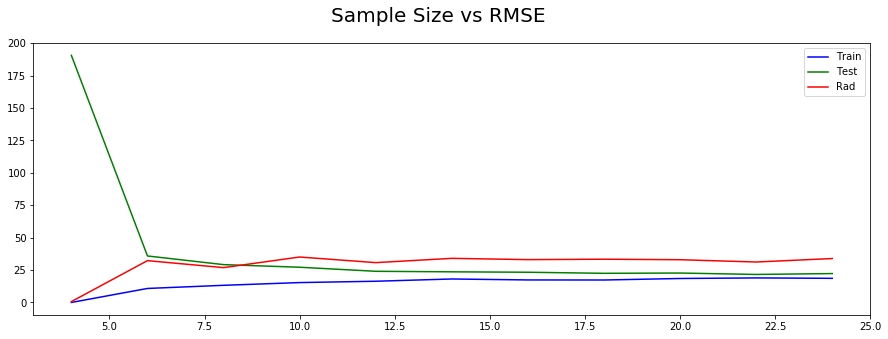

In [11]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
fig.suptitle('Sample Size vs RMSE',fontsize=20)
ax.plot(n,train_error,color='blue', label = 'Train')
ax.plot(n,test_error,color = 'green', label = 'Test')
ax.plot(n,radBound.reshape(-1,1), color = 'red', label = 'Rad')
ax.legend(loc='upper right')
plt.show()



In [12]:
#Step 4: Symbolic Regression (finding closed formula for test error depending only on sample size)
import gplearn as gpl 
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]

#fitting sumbolic regressor
est_gp = SymbolicRegressor(population_size=1000,
                           generations=10, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=5, random_state=0,
                           function_set = f_set)

sample = []
for i in n: 
    sample.append(i)  
sample = np.array([sample])
print(sample)

est_gp.fit(sample.reshape(-1,1),np.dot(1000,test_error))
print(est_gp._program)

[[ 4  6  8 10 12 14 16 18 20 22 24]]
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.73      4.97002e+14        5           8121.7          99320.3      7.82s
   1    11.77      7.52983e+07       12          7922.71           100352      8.62s
   2    11.30      3.01055e+08        6          7207.15          83327.5      6.27s
   3    11.28      4.33175e+09       11          6000.19            80753      5.61s
   4    12.35      7.51816e+08       21          5384.83          83522.1      4.91s
   5    12.59      1.24531e+14        9          3365.22          86486.9      4.96s
   6    13.92       2.2224e+14       11          3034.49          84543.2      3.28s
   7    16.30      9.03971e+09       13          3034.49          84543.2      2.14s
   8    19.43      7.13415e+09       2

MSE (test_error x symbolic regressor)
215.81582476019486


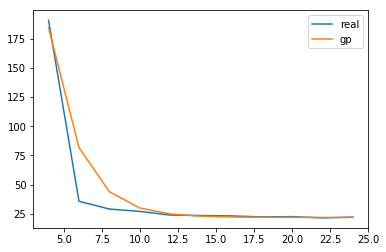

In [17]:
#Step 5: Evaluation for Symbolic Regressor
print("MSE (test_error x symbolic regressor)")
y = ((np.sqrt(np.exp(-sample)))*1200)+22
print(mean_squared_error(test_error, y.reshape(-1,1)))

plt.plot(sample.reshape(-1,1),test_error, label = 'real')
plt.plot(sample.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()


### Conclusions experiment 1: 
**Theoretical expectations for Empirical Error Estimation:**
<br>Similar conclusions as in Boston dataset.
<br>**Symbolic Regression Results:**
<br>Similar conclusions as in Boston dataset. Close-form expression for test error is:
$$ (c*\sqrt[2]{e^{-n}}+b) $$

### Experiment 2:  Evaluating how train and test error varies with increasing model capacity
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 15
<br>Train Samples = 10
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,10]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.datasets import load_boston
from random import sample

samples = 10
n_2 = range(0,100,1)
pw = range(1,11,1)

test_error = []
train_error = []
temp_test = []
temp_train = []
temp_L = []
Rad = []
h = 0

#Test set
df_x = ozone
df_x = df_x.drop(columns = ['ozone'])
df_y = ozone['ozone']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.12)


for i in pw:
    print("polyonomial: " + str(i))
    for j in n_2:
        #step 1 - train set
        idx = sample(range(0,len(X)), samples)
        X_train = X.iloc[idx]
        Y_train = Y.iloc[idx]
     
        Y_pred_train = np.empty_like(Y_train)
        Y_pred_test = np.empty_like(Y_test)
        
        #calculating polinomial features from 1 to 10 degree
        poly = PolynomialFeatures(degree = h+1) 
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.fit_transform(X_test)
    
        #rademacher sigma
        s = rademacher_variables(len(Y_train))

        #Step 2: model fitting
        #initialisation of linear regression/insert data for training/prediction
        m = LinearRegression()

        #inserting train data in model for training
        m.fit(X_poly_train,Y_train)

        #predicting values for test data
        Y_pred_test = m.predict(X_poly_test)
        Y_pred_train = m.predict(X_poly_train)

        #computing RMSE
        error_test= np.sqrt(mean_squared_error(Y_test, Y_pred_test))
        temp_test.append(error_test)

        error_train= np.sqrt(mean_squared_error(Y_train, Y_pred_train))
        temp_train.append(error_train)

         #Rademacher constant      
        temp_L.append(float(2*(np.dot(s, np.sqrt((Y_train-Y_pred_train)**2))/len(Y_train))))
    
    test_error.append(sum(temp_test)/len(temp_test))
    train_error.append(sum(temp_train)/len(temp_train))
    Rad.append((max(temp_L)))
    temp_test.clear()
    temp_train.clear()
    temp_L.clear()
    h += 1

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = rademacher_bound((np.array(samples))*np.ones(len(pw)), 0.1, np.array(train_error), np.array(Rad))
print("Rademacher Bound")
print(radBound)

polyonomial: 1
polyonomial: 2
polyonomial: 3
polyonomial: 4
polyonomial: 5
polyonomial: 6
polyonomial: 7
polyonomial: 8
polyonomial: 9
polyonomial: 10
Rademacher Constant
[14.873934393140422, 1.825392246246338e-08, 3.61524143954739e-12, 1.6484591469634324e-12, 1.4006218407303095e-11, 6.9675820668635426e-12, 9.57811607804615e-12, 6.176321676321095e-11, 1.232385216098919e-09, 3.9464964629587485e-10]
Rademacher Bound
[30.81166449  0.25962278  0.25962276  0.25962276  0.25962276  0.25962276
  0.25962276  0.25962276  0.25962276  0.25962276]


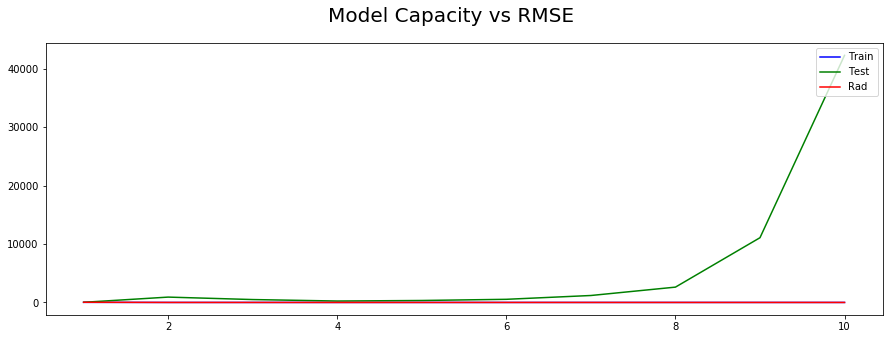

In [19]:
#Step 3: Evaluation

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,5))
fig.suptitle('Model Capacity vs RMSE',fontsize=20)
ax.plot(pw,train_error,color='blue', label = 'Train')
ax.plot(pw,test_error,color = 'green', label = 'Test')
ax.plot(pw,radBound.reshape(-1,1), color = 'red', label = 'Rad')
ax.legend(loc='upper right')
plt.show()



In [20]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=1000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.2, random_state=0,
                           function_set = f_set)

power = []
for i in pw: 
    power.append(i)  
print(power)
power = np.array([power])
print(test_error)
est_gp.fit(power.reshape(-1,1), test_error)
print(est_gp._program)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[25.748408118933913, 914.6519734272247, 494.3357635685172, 241.9703379295814, 334.89942137901505, 536.8066456614364, 1188.657762360883, 2620.4602520693106, 11077.364568676176, 42278.63238543965]
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.73       6.4457e+09       24           1039.9          24.7484     16.48s
   1    11.45      9.80296e+06       20          435.537          11372.2     21.15s
   2    12.89      8.95202e+08       17           415.67          11690.6     19.01s
   3    16.19       7.9596e+08       23          415.033          11700.7     18.58s
   4    17.11      2.24934e+09       17           415.67          11690.6     18.27s
   5    18.80       9.4642e+08       30          375.238          7351.85     19.74s
   6    18.87     

48782454.97501461


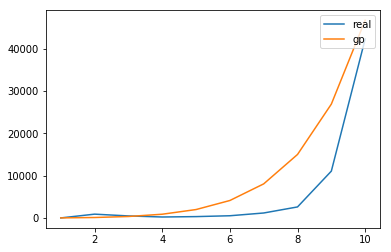

In [44]:
#Step 5: Evaluation for Symbolic Regressor
y = np.exp(np.sqrt(power)*3.4)
print(mean_squared_error(test_error, y.reshape(-1,1)))
plt.plot(power.reshape(-1,1),test_error, label = 'real')
plt.plot(power.reshape(-1,1),y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 2: 

**Theoretical expectations for Empirical Error Estimation:**
<br>Same results as in Boston dataset. 
<br>**Symbolic Regression Results:**
<br>Same results as in Boston dataset.


## Experiment 3:  Evaluating how train and test error varies by changing model capacity and sample size at the same time
Empirical train and test error: Root Mean Squared Error 
<br>Theoretical Bounds: Rademacher and VC Bounds for Regression 

Hyperparameters: 
<br>Test Samples = 25
<br>Train Samples = [4,6,8,10]
<br>Varying model capacity by adding polynomials with degrees = [1,2,3...,6]
<br>Run each polynomial 100 times and take the average for calculating the empirical erros to reduce noise. 

In [49]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from random import sample
import pandas as pd
import numpy as np

n = range(4,12, 2)
n_2 = range(0,100,1)
pw = range(1,7,1)
test_error = np.zeros([len(pw),len(n)])
train_error = np.zeros([len(pw),len(n)])
Rad = np.zeros([len(pw),len(n)])
temp = []
temp2= []
temp_train = []
temp2_train = []
temp_L = []
temp_L2 = []


#Test set
df_x = ozone
df_x = df_x.drop(columns = ['ozone'])
df_y = ozone['ozone']
X, X_test, Y, Y_test = train_test_split(df_x, df_y, test_size = 0.12)


for counter,value in enumerate(n): 
    print("Samples: ", str(value))
    for i in pw:
        print("power: ", str(i))
        for j in n_2:   
            #step 1 - train set
            idx = sample(range(0,len(X)), value)
            X_train = X.iloc[idx]
            Y_train = Y.iloc[idx]

            Y_pred_train = np.empty_like(Y_train)
            Y_pred_test = np.empty_like(Y_test)

            #creating polynomialfeatures
            poly = PolynomialFeatures(degree = i) 
            X_train_poly = poly.fit_transform(X_train) 
            X_test_poly = poly.fit_transform(X_test) 

            #rademacher sigma
            s = rademacher_variables(len(Y_train))
            
            #step 2 - model training
            #initialisation of linear regression 
            m = LinearRegression()

            #inserting train data in model for training
            m.fit(X_train_poly,Y_train)

            #predicting values for test data
            Y_pred = m.predict(X_test_poly)
            Y_pred_train = m.predict(X_train_poly)

            #computing RMSE for train and test
            error = np.sqrt(mean_squared_error(Y_test, Y_pred))
            temp.append(error) 
            error_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
            temp_train.append(error_train)
            
            #computing Rademacher constant
            L = (2*np.dot(s, np.sqrt((Y_train-Y_pred_train)**2)))/len(Y_train)
            temp_L.append(L)


        temp2.append(sum(temp) / len(temp))
        temp2_train.append(sum(temp_train)/len(temp_train))
        temp_L2.append(max(temp_L))
        temp.clear()
        temp_train.clear()
        temp_L.clear()
    test_error[:,counter] = temp2
    train_error[:,counter] = temp2_train
    Rad[:,counter] = temp_L2
    temp2.clear()
    temp2_train.clear()
    temp_L2.clear()

#Calculating Rademacher and VC Bounds
print("Rademacher Constant")
print(Rad)
radBound = np.zeros([len(pw),len(n)])
c =3*(np.sqrt(np.log(2/0.1))/(2*(np.array(n))))
for i in range(0,len(pw)):
    radBound[i] = np.add(train_error[i], Rad[i])
    radBound[i] = np.add(radBound[i],c)
print("Rademacher Bound")
print(radBound)

Samples:  4
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  6
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  8
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Samples:  10
power:  1
power:  2
power:  3
power:  4
power:  5
power:  6
Rademacher Constant
[[9.09494702e-13 1.92371339e+01 1.53686862e+01 1.28375574e+01]
 [2.27373675e-13 1.26950302e-12 3.54702934e-11 4.28408384e-09]
 [6.25277607e-13 1.83320026e-12 2.40873987e-12 8.54925020e-12]
 [4.26325641e-13 4.11641092e-12 3.12638804e-12 9.09494702e-12]
 [1.76214598e-12 6.50857146e-12 4.88853402e-12 1.53477231e-11]
 [1.41175960e-11 8.04156741e-12 6.29718500e-12 8.53788151e-12]]
Rademacher Bound
[[ 0.67322493 30.06815908 28.89404742 27.91067833]
 [ 0.64905689  0.4327046   0.32452845  0.25962276]
 [ 0.64905689  0.4327046   0.32452845  0.25962276]
 [ 0.64905689  0.4327046   0.32452845  0.25962276]
 [ 0.64905689  0.4327046   0.32452845  0.25962276]
 [ 0.64905689  0.4327046   0.32452845  0

Min RMSE:  23.96001993510338
Position of min RMSE:  (array([0], dtype=int64), array([3], dtype=int64))
[1, 2, 3, 4, 5, 6]
[4, 6, 8, 10]

Min RMSE for each polynomial 
[ 23.96001994  58.87354907  87.82243704 116.59264041 210.20375234
 452.38590406]


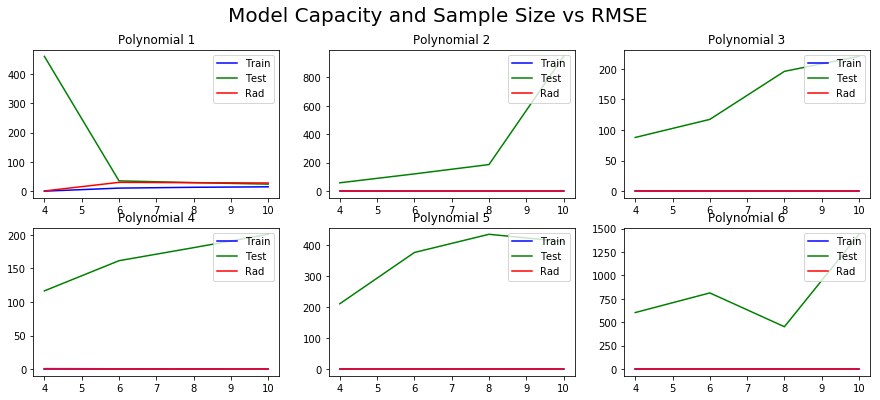

In [50]:
#Step 3: evaluation
import matplotlib.pyplot as plt

print("Min RMSE: ", np.amin(test_error))
pos = np.where(test_error== np.amin(test_error))
print('Position of min RMSE: ', pos)
print(list(pw))
print(list(n))

print('\nMin RMSE for each polynomial ')
print(np.amin(test_error, axis = 1))


#plotting
fig, axs = plt.subplots(2,3, figsize=(15, 6))
fig.suptitle('Model Capacity and Sample Size vs RMSE',fontsize=20)
axs = axs.flatten()
for i in pw:
    axs[i-1].plot(n, train_error[i-1,:], color = 'blue', label = 'Train')
    axs[i-1].plot(n, test_error[i-1,:], color = 'green', label = 'Test')
    axs[i-1].plot(n, radBound[i-1], color = 'red', label = 'Rad')
    axs[i-1].legend(loc='upper right')
    axs[i-1].set_title("Polynomial %d" %i)
plt.show()

In [62]:
#Step 4: Symbolic Regression
import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

# Create custom operations (exp) to be considered in the tree
def xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a 

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )
f_set = function_set = ['add','mul', 'div', 'log', 'sqrt', 'neg', xexp]
est_gp = SymbolicRegressor(population_size=2000, metric = 'rmse',
                           generations=30, stopping_criteria=5000,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.1, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=20, random_state=0,
                           function_set = f_set)
power = []
samples = []
for i in pw: 
    power.append(i)  
for i in n: 
    samples.append(i)  

a = np.transpose([ np.repeat(samples, len(power)), np.tile(power, len(samples))])
error = np.array(list(test_error.flatten()))
est_gp.fit(a,100*error)
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.59      7.13871e+15       21          23407.4          74490.6     46.13s
   1    10.78      1.59208e+10       13          15165.5          66690.6     51.25s
   2    11.26      4.27597e+10       10          14570.2          68988.6     47.25s
   3    12.84      9.81535e+10       17          14570.2          68988.6     46.62s
   4    12.30      7.23962e+10       11          14488.2          69108.1     43.65s
   5    12.54      3.50238e+11        9          14679.3          67436.4     44.16s
   6    12.78      5.70528e+10       21          14948.3          67155.6     42.83s
   7    13.23      1.52492e+10       13          14525.3          67103.7     41.37s
   8    13.65      1.03983e+10       15          14046.9          67646.1  

MSE (test_error x symbolic regressor)
74937.72806625375


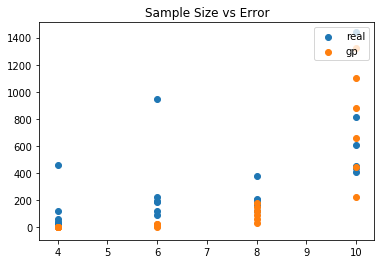

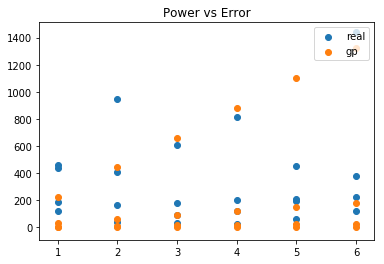

In [63]:
#Step 5: Evaluation for Symbolic Regressor
y = ((np.exp(a[:,0])* a[:,1])+ np.sqrt(a[:,1]))/100

print("MSE (test_error x symbolic regressor)")
print(mean_squared_error(error, y.reshape(-1,1)))

plt.title("Sample Size vs Error")
plt.scatter(a[:,0],error, label = 'real')
plt.scatter(a[:,0],y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()
plt.title("Power vs Error")
plt.scatter(a[:,1],error, label = 'real')
plt.scatter(a[:,1],y.reshape(-1,1), label = 'gp')
plt.legend(loc='upper right')
plt.show()

### Conclusions experiment 3: 
**Empirical Error Estimation Results:**
<br>For Multivariate regression and this dataset, the best results were found when power = 1 at a model trained with 8 samples. By adding more polinomials, the model clearly overfits.
<br>As in all other experiments, once model capacity is added the theoretical bounds do not approximate test_error well. 

**Symbolic Regression Results:**
<br>Symbolic regression finds a mathematical equation that relates model capacity and test error.
<br> $$ (e^{n}*pw) + sqrt(pw) $$

Where n is the number the sample size, pw is the model capacity and c is a constant. 